Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Dataset merged successfully.
Shape: (18361, 26)

Columns:
 ['CustomerID', 'Title', 'FirstName', 'MiddleName', 'LastName', 'Suffix', 'AddressLine1', 'AddressLine2', 'City', 'StateProvinceName', 'CountryRegionName', 'PostalCode', 'PhoneNumber', 'BirthDate', 'Education', 'Occupation', 'Gender', 'MaritalStatus', 'HomeOwnerFlag', 'NumberCarsOwned', 'NumberChildrenAtHome', 'TotalChildren', 'YearlyIncome', 'LastUpdated', 'BikeBuyer', 'AvgMonthSpend']

Preview:
    CustomerID Title FirstName MiddleName  LastName Suffix  \
0       21173   NaN      Chad          C      Yuan    NaN   
1       13249   NaN      Ryan        NaN     Perry    NaN   
2       29350   NaN     Julia        NaN  Thompson    NaN   
3       13503   NaN  Theodore        NaN     Gomez    NaN   
4       22803   NaN  Marshall          J      Shan    NaN   

             AddressLine1 AddressLine2      

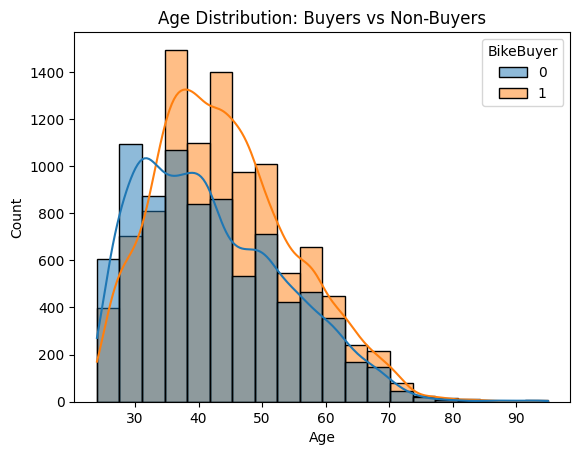

Mann-Whitney U test: p=0.0000
Age distribution differs

Q5. Bike Buyer % by Marital Status:
  MaritalStatus  BikeBuyer_Percentage
0             M             63.838343
1             S             44.937010


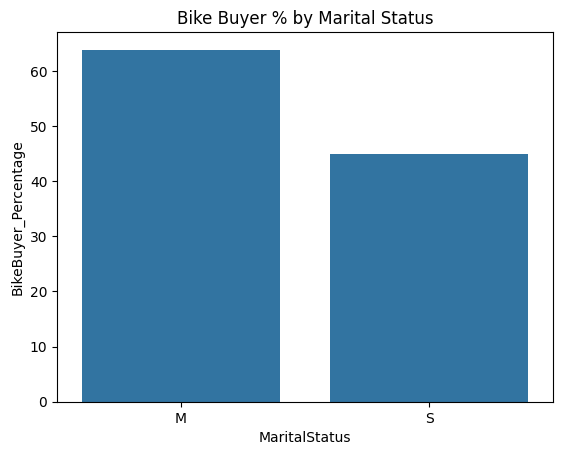


Chi-square test p=0.0000
 Significant difference


In [5]:
# -----------------------------------------------
# Assignment-3 : Adventure Works Cycles Customer Data
# -----------------------------------------------

#  Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# -----------------------------------------------
#  Load CSV files from Google Drive
# -----------------------------------------------
# Change the folder name if your files are in a different folder
customers_path = "/content/drive/MyDrive/AWCustomers.csv"
sales_path = "/content/drive/MyDrive/AWSales.csv"

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, mannwhitneyu, chi2_contingency

# Load the datasets
customers = pd.read_csv(customers_path)
bike_buyer = pd.read_csv(sales_path)

# -----------------------------------------------
# Q1 (a) Merge datasets
# -----------------------------------------------
df = pd.merge(customers, bike_buyer, on="CustomerID", how="inner")

print(" Dataset merged successfully.")
print("Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())
print("\nPreview:\n", df.head())

# -----------------------------------------------
# Q1(a) Feature Selection — keep relevant columns only
# -----------------------------------------------
remove_cols = [
    'Title', 'FirstName', 'MiddleName', 'LastName', 'Suffix',
    'AddressLine1', 'AddressLine2', 'City', 'StateProvinceName',
    'CountryRegionName', 'PostalCode', 'PhoneNumber', 'LastUpdated'
]

df_selected = df.drop(columns=[c for c in remove_cols if c in df.columns])
print("\nQ1(a) Selected Features:\n", df_selected.columns.tolist())

# -----------------------------------------------
# Q1(b) Create new DataFrame with selected features
# -----------------------------------------------
data = df_selected.copy()
print("\nQ1(b) New DataFrame:")
print(data.head())

# -----------------------------------------------
# Q1(c) Data value type classification
# -----------------------------------------------
print("\nQ1(c) Attribute Type Classification:")
type_map = {
    'CustomerID': 'Nominal (Identifier)',
    'BirthDate': 'Interval (can derive Age)',
    'Education': 'Ordinal',
    'Occupation': 'Nominal',
    'Gender': 'Nominal',
    'MaritalStatus': 'Nominal',
    'HomeOwnerFlag': 'Binary (Nominal)',
    'NumberCarsOwned': 'Discrete (Ratio)',
    'NumberChildrenAtHome': 'Discrete (Ratio)',
    'TotalChildren': 'Discrete (Ratio)',
    'YearlyIncome': 'Continuous (Ratio)',
    'BikeBuyer': 'Binary (Nominal)',
    'AvgMonthSpend': 'Continuous (Ratio)'
}

for k, v in type_map.items():
    if k in data.columns:
        print(f"{k} → {v}")

# -----------------------------------------------
# Q2. Is there a significant difference in average income?
# -----------------------------------------------
print("\nQ2. Average Income Comparison:")
income_bike = data[data['BikeBuyer'] == 1]['YearlyIncome']
income_non = data[data['BikeBuyer'] == 0]['YearlyIncome']

print("Avg Income (Buyers):", income_bike.mean())
print("Avg Income (Non-Buyers):", income_non.mean())

t_stat, p_value = ttest_ind(income_bike, income_non, equal_var=False)
print(f"T-test result: t={t_stat:.3f}, p={p_value:.4f}")
print(" Significant difference" if p_value < 0.05 else " No significant difference")

# -----------------------------------------------
# Q3. Bike purchase % by CommuteDistance
# -----------------------------------------------
if 'CommuteDistance' in data.columns:
    commute_stats = (
        data.groupby('CommuteDistance')['BikeBuyer']
        .mean().mul(100)
        .reset_index()
        .rename(columns={'BikeBuyer': 'Purchase_Percentage'})
    )

    print("\nQ3. Purchase % by Commute Distance:")
    print(commute_stats)

    sns.barplot(x='CommuteDistance', y='Purchase_Percentage', data=commute_stats)
    plt.title('Bike Purchase % by Commute Distance')
    plt.show()
else:
    print("\nQ3. CommuteDistance column not found in this dataset.")

# -----------------------------------------------
# Q4. Age distribution difference (Buyers vs Non-Buyers)
# -----------------------------------------------
print("\nQ4. Age Distribution Difference:")

# Convert BirthDate → Age (in years)
data['BirthDate'] = pd.to_datetime(data['BirthDate'], errors='coerce')
data['Age'] = (pd.Timestamp('today') - data['BirthDate']).dt.days // 365

sns.histplot(data=data, x='Age', hue='BikeBuyer', kde=True, bins=20)
plt.title('Age Distribution: Buyers vs Non-Buyers')
plt.show()

u_stat, p_val = mannwhitneyu(
    data[data['BikeBuyer'] == 1]['Age'].dropna(),
    data[data['BikeBuyer'] == 0]['Age'].dropna()
)
print(f"Mann-Whitney U test: p={p_val:.4f}")
print("Age distribution differs" if p_val < 0.05 else " No significant age difference")

# -----------------------------------------------
# Q5. Proportion of bike buyers across Marital Status
# -----------------------------------------------
print("\nQ5. Bike Buyer % by Marital Status:")
marital_stats = (
    data.groupby('MaritalStatus')['BikeBuyer']
    .mean().mul(100)
    .reset_index()
    .rename(columns={'BikeBuyer': 'BikeBuyer_Percentage'})
)
print(marital_stats)

sns.barplot(x='MaritalStatus', y='BikeBuyer_Percentage', data=marital_stats)
plt.title('Bike Buyer % by Marital Status')
plt.show()

# Chi-square test
cont_table = pd.crosstab(data['MaritalStatus'], data['BikeBuyer'])
chi2, p, dof, expected = chi2_contingency(cont_table)
print(f"\nChi-square test p={p:.4f}")
print(" Significant difference" if p < 0.05 else " No significant difference")
